In [1]:
import pandas as pd
from sklearn.cluster import KMeans, BisectingKMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import datetime
import os
from collections import Counter

# import warnings
# warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning")

In [2]:
class Clustering:
    def __init__(self, filename, n_clusters=5):
        self.filename = filename
        self.n_clusters = n_clusters

        self.cluster = {}
        self.cluster_center = {}
        self.labels = {}

        self.load_data()

    def load_data(self):
        self.data = pd.read_csv(self.filename)
        self.feature_data = self.data.iloc[:, [4, 5, 6]].copy()
        self.xyz_data = self.data.iloc[:, [0, 1, 2]].copy()

    def apply_clustering_algorithms(self):

        #K-means, Bisecting K-means, Mini-Batch K-means, Gaussian Mixture, Bayesian Gaussian Mixture
        self.algorithms = {
            'KMeans': KMeans(n_clusters=self.n_clusters),
            # 'BisectingKMeans': BisectingKMeans(n_clusters=self.n_clusters),
            # 'MiniBatchKMeans': MiniBatchKMeans(n_clusters=self.n_clusters),
            # 'GaussianMixture': GaussianMixture(n_components=self.n_clusters),
            # 'BayesianGaussianMixture': BayesianGaussianMixture(n_components=self.n_clusters)
        }
        
        print("***apply_clustering_algorithms start***\n")

        X = self.feature_data.to_numpy()
        
        for name, algorithm in self.algorithms.items():
            print(f"{name} algorithms is running ... ")

            self.cluster[name] = algorithm.fit(X)
            
            if( hasattr(self.cluster[name], 'labels_')): self.labels[name] = self.cluster[name].labels_
            elif( hasattr(self.cluster[name], 'fit_predict')): self.labels[name] = self.cluster[name].fit_predict(X)

            if( hasattr(self.cluster[name], 'cluster_centers_')): self.cluster_center[name] = self.cluster[name].cluster_centers_
            elif( hasattr(self.cluster[name], 'predict_proba')): self.cluster_center[name] = self.cluster[name].predict_proba(X)

        print("done")

        print("\n***apply_clustering_algorithms end***")


    def evaluate_clusters(self):
        scores = {}
        for name, labels in self.labels.items():
            if len(set(labels)) > 1:  # Evaluate only when there are more than one cluster

                # silhouette = silhouette_score(self.feature_data, labels)
                # davies = davies_bouldin_score(self.feature_data, labels)
                # calinski = calinski_harabasz_score(self.feature_data, labels)
                # scores[name] = (silhouette, davies, calinski)

                scores[name] = (1, 1, 1)
        return scores
    

    def find_best_algorithm(self):
        self.apply_clustering_algorithms()
        self.scores = self.evaluate_clusters()
        print("-----------------------------------")
        best_silhouette = max(self.scores, key=lambda x: self.scores[x][0])
        best_davies = min(self.scores, key=lambda x: self.scores[x][1])
        best_calinski = max(self.scores, key=lambda x: self.scores[x][2])
        print(f"Best by Silhouette : ({best_silhouette}, {self.scores[best_silhouette]}),")
        print(f"Best by Davies-Bouldin : ({best_davies}, {self.scores[best_davies]}),")
        print(f"Best by Calinski-Harabasz : ({best_calinski}, {self.scores[best_calinski]})")
        print("-----------------------------------")

        best_algorithms = [best_silhouette, best_davies, best_calinski]

        counts = [Counter(string) for string in best_algorithms]
        best_algorithm = max(best_algorithms, key=lambda x: counts[best_algorithms.index(x)][x])
        return best_algorithm

    def run(self):
        self.best_algorithm = self.find_best_algorithm()
        self.xyz_data['Cluster'] = self.labels[self.best_algorithm]
        

In [3]:
clustering = Clustering('data_points\\normalized_data_points.csv', n_clusters=10)  # Set the CSV file path and number of clusters
clustering.run()
print("\n\n***clustered dataframe***\n\n",clustering.xyz_data)

***apply_clustering_algorithms start***

KMeans algorithms is running ... 


c:\Users\chobl\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


done

***apply_clustering_algorithms end***
-----------------------------------
Best by Silhouette : (KMeans, (1, 1, 1)),
Best by Davies-Bouldin : (KMeans, (1, 1, 1)),
Best by Calinski-Harabasz : (KMeans, (1, 1, 1))
-----------------------------------


***clustered dataframe***

                x         y         z  Cluster
0       0.085965  0.085645  0.296932        4
1      -0.086027  0.298432  0.166735        0
2      -0.097432 -0.249213  0.081169        7
3       0.049463 -0.378217  0.202134        1
4       0.073233  0.095633  0.108575        1
...          ...       ...       ...      ...
399995  0.073627 -0.281739  0.304017        8
399996 -0.149384 -0.022435  0.579944        0
399997 -0.076774  0.084694  0.606595        4
399998  0.000786  0.117486  0.050482        6
399999  0.026135  0.010946  0.642926        8

[400000 rows x 4 columns]


In [4]:
class Defining_relative_levels:
    def __init__(self, clustering):
        self.xyz_data = clustering.xyz_data
        self.cluster_center = clustering.cluster_center[clustering.best_algorithm]

    def get_sorted_cluster_centers(self):
        # Calculate the Euclidean distance from each center point to (0,0)
        distances = np.linalg.norm(self.cluster_center, axis=1)
        # Sort centroid points by distance
        sorted_indices = np.argsort(distances)

        return {value : index for index, value in enumerate(sorted_indices)}
    
    def difine_relative_levels(self, sorted_dict):
        temp = self.xyz_data['Cluster'].copy()
        relative_level = []
        for i in range(len(temp)): relative_level.append(sorted_dict[temp[i]])
        self.xyz_data['Cluster'] = relative_level

    def run(self):
        self.sorted_dict = self.get_sorted_cluster_centers()
        self.difine_relative_levels(self.sorted_dict)

In [5]:
defining_relative_level = Defining_relative_levels(clustering)
defining_relative_level.run()
print("Relative level dictionary : ", defining_relative_level.sorted_dict, end="\n\n")
print("\n\n***Data with defined relative level***\n\n",defining_relative_level.xyz_data)

Relative level dictionary :  {3: 0, 9: 1, 8: 2, 4: 3, 1: 4, 5: 5, 0: 6, 6: 7, 7: 8, 2: 9}



***Data with defined relative level***

                x         y         z  Cluster
0       0.085965  0.085645  0.296932        3
1      -0.086027  0.298432  0.166735        6
2      -0.097432 -0.249213  0.081169        8
3       0.049463 -0.378217  0.202134        4
4       0.073233  0.095633  0.108575        4
...          ...       ...       ...      ...
399995  0.073627 -0.281739  0.304017        2
399996 -0.149384 -0.022435  0.579944        6
399997 -0.076774  0.084694  0.606595        3
399998  0.000786  0.117486  0.050482        7
399999  0.026135  0.010946  0.642926        2

[400000 rows x 4 columns]


In [11]:
class Visualization_UoCs:
    def __init__(self, data):
        self.df = data.xyz_data

    def plot_all_UoCs(self, elev=90, azim=0):
        # Create a new 3D plo
        fig = plt.figure(figsize=(10, 10))  # Set the size of the entire graph
        ax = fig.add_subplot(111, projection='3d')

        # 각 클러스터 별로 다른 색상으로 점 표시
        clusters = self.df['Cluster'].unique()
        clusters = sorted(clusters)

        colors = plt.cm.jet(np.linspace(0, 1, len(clusters)))  # Generate colors based on the number of clusters

        for cluster, color in zip(clusters, colors):
            # Filter only data from that cluster
            cluster_data = self.df[self.df['Cluster'] == cluster]
            ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], c=[color], label=f'UoC {cluster+1}', alpha=0.5)

        # Setting axis labels
        ax.set_xlabel('X')
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylabel('Y')
        ax.set_ylim(-0.5, 0.5)
        ax.set_zlabel('Z')
        ax.set_zlim(0.0, 0.8)

        ax.view_init(elev=elev, azim=azim)  # 'elev' to adjust the angle in height, 'azim' to adjust the angle of rotation around the Y axis

        ax.legend()

        plt.show()

    def plot_each_cluster(self, elev=90, azim=0):

        clusters = self.df['Cluster'].unique()
        clusters = sorted(clusters)
        
        num_clusters = len(clusters)
        colors = plt.cm.jet(np.linspace(0, 1, num_clusters)) 

        # Create a subplot for each cluster
        fig = plt.figure(figsize=(90, 10)) 
        
        for i, (cluster, color) in enumerate(zip(clusters, colors), 1):
            # ax = fig.add_subplot(2, (num_clusters + 1) // 2, i, projection='3d')  # Place subplot in 2 rows
            ax = fig.add_subplot(1, (num_clusters + 1), i, projection='3d')  # Place subplot in 1 rows

            cluster_data = self.df[self.df['Cluster'] == cluster]
            ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], c=[color], alpha=0.3)

            ax.set_title(f'UoC {cluster+1}')
            # Setting axis labels
            ax.set_xlabel('X')
            ax.set_xlim(-0.5, 0.5)
            ax.set_ylabel('Y')
            ax.set_ylim(-0.5, 0.5)
            ax.set_zlabel('Z')
            ax.set_zlim(0.0, 0.8)

            ax.view_init(elev=elev, azim=azim)  # 'elev' to adjust the angle in height, 'azim' to adjust the angle of rotation around the Y axis

        # 그래프 표시
        plt.show()

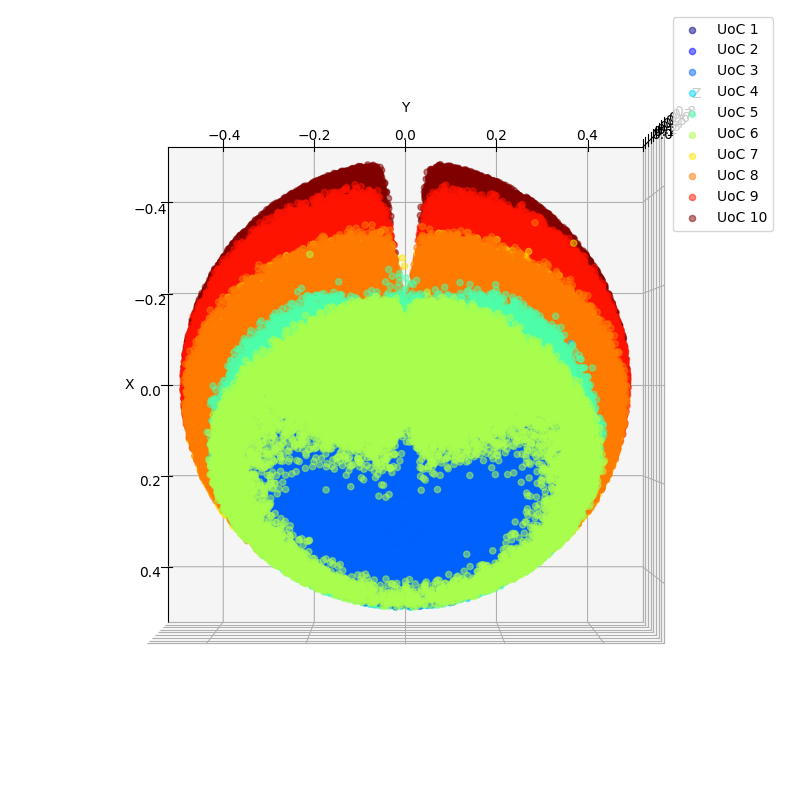

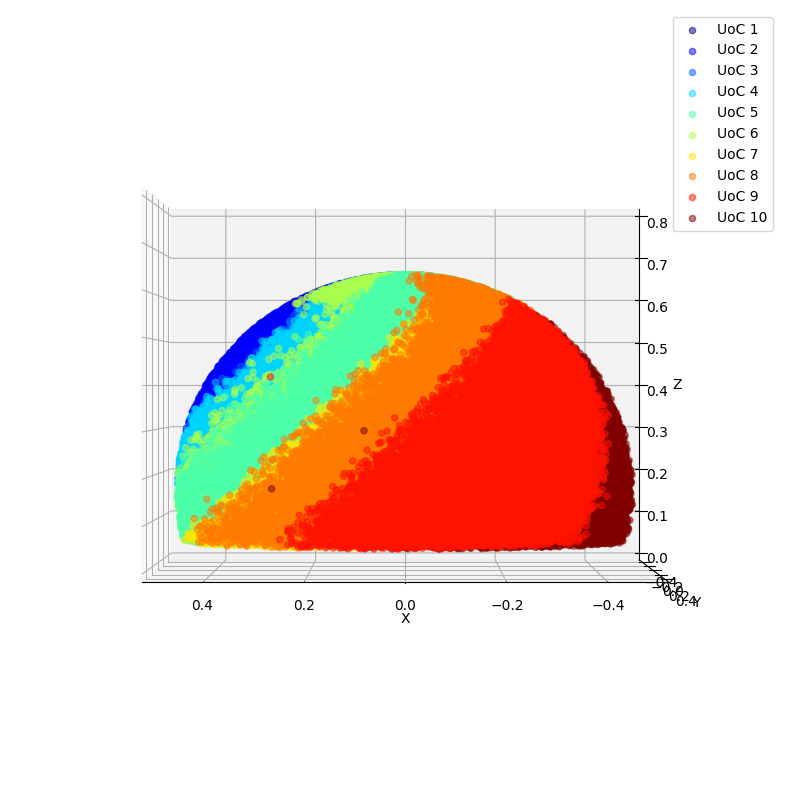

In [7]:
visualizer = Visualization_UoCs(defining_relative_level)
visualizer.plot_all_UoCs(90,0)
visualizer.plot_all_UoCs(0,90)

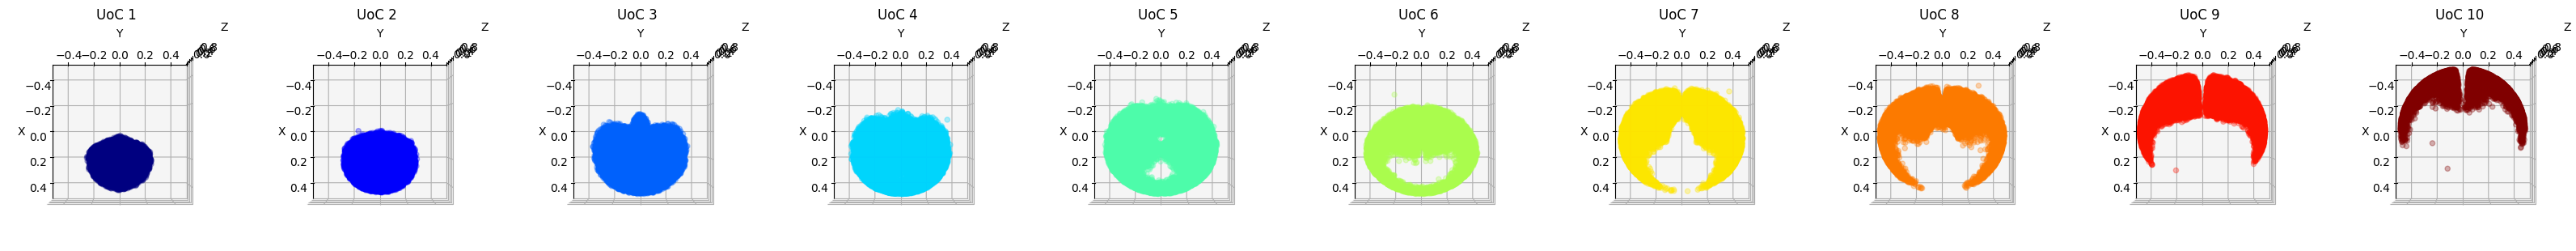

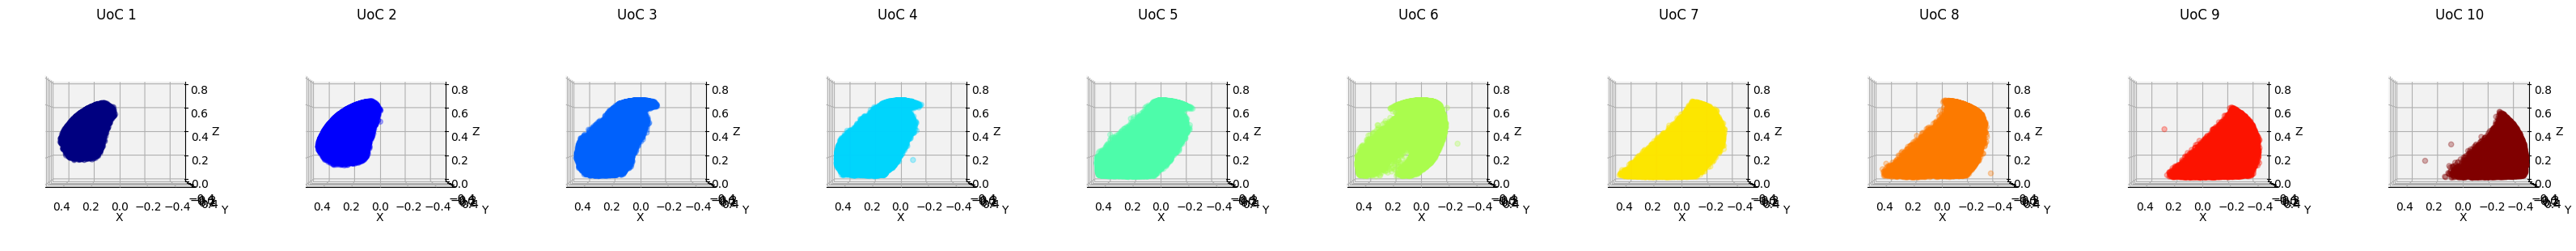

In [12]:
visualizer.plot_each_cluster(90,0)
visualizer.plot_each_cluster(0,90)

In [13]:
class CSVExporter:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.clusters = sorted(dataframe['Cluster'].unique())
        self.num_of_cluster = "UoC_" + str(len(self.clusters))+ "_"

        now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        self.folder_path1 = os.path.join(os.getcwd(), "Uoc_data")
        self.folder_path2 = os.path.join(self.folder_path1, self.num_of_cluster + now)

        self.make_folder(self.folder_path1)
        self.make_folder(self.folder_path2)

    def make_folder(self, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    
    def save_to_csv(self):
        """Split the data by each cluster and save the data, excluding the Cluster column, as a CSV file"""
        for cluster in self.clusters:
            cluster_data = self.dataframe[self.dataframe['Cluster'] == cluster].copy()
            cluster_data.drop('Cluster', axis=1, inplace=True)  # Cluster 열을 삭제합니다.

            file_path = os.path.join(self.folder_path2, f'UoC_{cluster+1}.csv')

            cluster_data.to_csv(file_path, index=False)  # 인덱스를 포함하지 않고 CSV 파일로 저장
            print(f"UoC_{cluster+1}: {len(cluster_data)} pieces of data")


In [14]:
# Pass the DataFrame to the class and call the method to save each cluster as a CSV file
exporter = CSVExporter(defining_relative_level.xyz_data)
exporter.save_to_csv()

UoC_1: 29169 pieces of data
UoC_2: 31906 pieces of data
UoC_3: 47500 pieces of data
UoC_4: 47260 pieces of data
UoC_5: 50595 pieces of data
UoC_6: 47822 pieces of data
UoC_7: 50468 pieces of data
UoC_8: 36171 pieces of data
UoC_9: 36845 pieces of data
UoC_10: 22264 pieces of data
